# <font style="color:blue">Assignment: Implement the Adam Optimizer</font>

In machine learning, our objective function is the loss that we minimize using different optimizers. Optimizers can optimize any function, whether it is a loss function or any other function. 

In this assignment, we will minimize a very simple function (a parabola) using an adam optimizer. You have to implement the gradient of the function and the adam optimizer. 


## <font color='blue'>Marking Scheme</font>

#### Maximum Points: 30

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Problem</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>3. Implement the Gradient</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>4. Implement the Adam Optimizer</h3></td> <td><h3>25</h3></td> </tr>
    </table>
</div>

In [15]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import math
import copy

import time
from collections import defaultdict

import matplotlib.pyplot as plt
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font style="color:green">1. The Objective Function</font>

**The objective function is the f0llowing:**
$$
f(x) = x^2 -5x + 6
$$

Have to find the value of $x$ for which the value of the function will be minimum.


**In the following cell, the function has been implemented.**

In [17]:
def function(x):
    fun = x**2 - 5*x + 6
    return fun

# <font style="color:green">2. The Visualizer</font>

**In this section, we have code to visualize the function and the learning process to find a minimum.**

In [18]:
plt.rcParams["figure.figsize"] = (8, 8)

In [19]:
class MatplotlibVisualizer:
    def __init__(self):
        
        self.plotdic = {
            'x': [],
            'y': [],
            'color': 'b',
            'linestyle': '-',
            'label': None,
            'linewidth': 1
        }
        self.plots = defaultdict(list)
        self._figures = {}
        self._axes = {}
        

    def init_new_figure(self, name, xlabel, ylabel, dic_list=[]):
        if len(dic_list) == 0:
            dic_list.append(self.plotdic)
        fig, ax = plt.subplots(1, 1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        fig.suptitle(name, fontsize=10)
        self._figures[name] = fig
        self._axes[name] = ax
        for dic in dic_list:
            d = dict()
            for key, value in copy.deepcopy(self.plotdic).items():
                d[key] = dic.get(key, value)
            self.plots[name].append(d)
            
        return

    def plot(self):
        for key, value in self.plots.items():
            
            ax = self._axes[key]
            fig = self._figures[key]
            labels = []
            for plot in self.plots[key]:
                ax.plot(plot['x'], plot['y'], linestyle=plot['linestyle'], 
                        linewidth=plot['linewidth'], color=plot['color'])
                
                if len(plot['x']) > 0:
                    labels.append(plot['label'])
                
            ax.legend(labels) 
            ax.relim()
            ax.autoscale_view()
            fig.canvas.draw()
        plt.show()

    def _update_plots(self, name, new_x, new_y, plot_num):
        self.plots[name][plot_num]['x'].append(new_x)
        self.plots[name][plot_num]['y'].append(new_y)

    def update_charts(self, name, new_x, new_y, plot_num=0):
        self._update_plots(name, new_x, new_y, plot_num)
        self.plot()

<IPython.core.display.Javascript object>


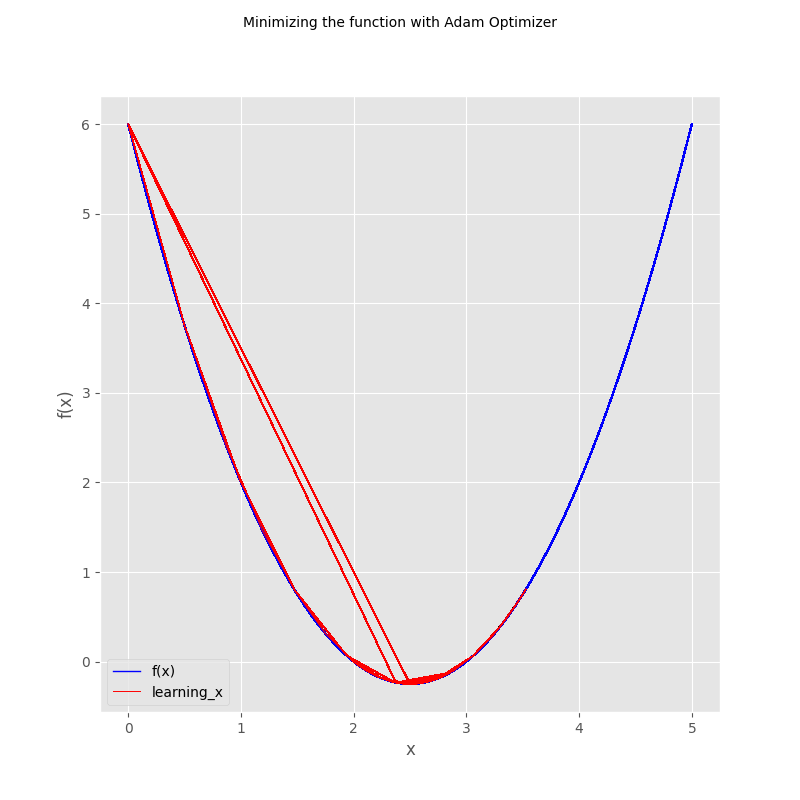

In [20]:

# values of x
x = torch.linspace(0, 5, 100)

# f(x) for all x
y = function(x)

# plot name
plt_name = 'Minimizing the function with Adam Optimizer'


xlabel = 'x'
ylabel = 'f(x)'

# init the visualizer class
viz = MatplotlibVisualizer()

# dictionary for function plot
dic = {
    'color': 'b',
    'label': 'f(x)'
}

# dictionary for learning plot
dic1 = {
    'color': 'r',
    'label': 'learning_x',
    'linewidth': 0.7
}
viz.init_new_figure(plt_name, xlabel, ylabel, dic_list=[dic, dic1])

# let's plot the function
for i in range(len(x)):
    viz.update_charts(plt_name, x[i], y[i], plot_num=0)
    
    

# <font style="color:green">3. Implement the Gradient [5 Points]</font>

**You have to implement the gradient of the function ($f(x) = x^2 -5x + 6$).**

In [21]:
def grad_function(x):
    grad_fun = 2*x-5
    return grad_fun

In [7]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


# <font style="color:green">4. Implement the Adam Optimizer [25 Points]</font>

**Adam update rule:**
$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
\hat{v_t} &= \frac{v_t}{1 - {\beta_1}^t} \\
\\
\hat{s_t} &= \frac{s_t}{1 - {\beta_2}^t} \\
\\
x_t &= x_{t-1} - \alpha \frac {\hat{v_{t}}}{\sqrt {\hat{s_t}} + \epsilon} \\
\end{align}
$$

**In this section, you have to implement the adam optimizer. Write your code where is specified, do not change anything else.**

Find the paper of Adam Optimizer [here](https://arxiv.org/pdf/1412.6980.pdf).

In [27]:
class AdamOptimizer(nn.Module):
    
    def __init__(self, alpha=0.5, beta_1=0.9, beta_2=0.99, epsilon=1e-8):
        super().__init__()
        
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.v_current = 0
        self.s_current = 0
        self.iter_next = 0
        
    def forward(self, x_current, grad):
        
        self.iter_next = self.iter_next + 1
        
        self.v_current = self.beta_1*self.v_current + (1 - self.beta_1)*grad 
        self.s_current = self.beta_2*self.s_current + (1 - self.beta_2)*(grad**2)
        
        v_hat = self.v_current/(1- self.beta_1**self.iter_next)
        s_hat = self.s_current/(1- self.beta_2**self.iter_next)

        x_next = x_current - self.alpha* v_hat/(math.sqrt(s_hat)+self.epsilon)

        #print("current iter is:", self.iter_next, "x_current is", x_current, "x_next corrected is", x_next)
        return x_next
        

In [8]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


# <font style="color:green">5. Check your Implementations</font>

**Let's start with $x=0$ and find the value of $x$ for which the function will have the minimum value. The following function will also return the `number of iteration` to reach this value.**


In [23]:
def find_minimum(initial_x, fun, grad_fun, x_change_stop_value=1e-5):
    current_x = initial_x
    optimizer = AdamOptimizer()
    viz.update_charts(plt_name, initial_x, fun(initial_x), plot_num=1)
    num_iter = 0
    wait = 0
    while True:
        f = fun(current_x)
        g_f = grad_fun(current_x)
        x_next = optimizer(current_x, g_f)
        viz.update_charts(plt_name, x_next, fun(x_next), plot_num=1)
        num_iter += 1
        if abs(current_x - x_next) < x_change_stop_value:
            wait += 1
        else:
            wait = 0
            
        if wait > 10:
            break
        current_x = x_next
            
    return x_next, num_iter
    

**Running the below cell, you should get the following outputs:**

```
Value of x: 2.5, number of iteration: 234
```

**The function will have a minimum value at $x = 2.5$. We can reached close enough!!**

In [28]:
x, num_iteration = find_minimum(0, function, grad_function)
print('Value of x: {0:.5}, number of iteration: {1}'.format(x, num_iteration))

Value of x: 2.5, number of iteration: 234
